#  Modelo de ZeeHB

Sample of notebook for specific model

In [36]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [37]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
from hep import *

In [38]:
def func(k, M1, M2, MAo, Mho, MHo, v, lam2, lam6, lam7, lam9, lam10, lamh, Muh, Mu2):
    M12 = M1*M1; M22 = M2*M2; MAo2 = MAo*MAo; Mho2 = Mho*Mho; MHo2 = MHo*MHo; Mu22 = Mu2*Mu2; Muh2 = Muh*Muh 
    phi = 0.5*np.arcsin((4*np.pi)**2*k/(np.log(M22/M12)))
    Mu  = (M22-M12)*np.sin(2.0*phi)/(np.sqrt(2)*v)
    MH2 = M12*(np.sin(phi))**2+M22*(np.cos(phi))**2
    M332 = M12*(np.cos(phi))**2+M22*(np.sin(phi))**2
    lam1 = 0.5*(MHo2+Mho2-np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2))/(v**2)
    lam3 = 2.0*(MH2-Mu22)/(v**2)
    lam4 = 0.5*(np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2)+MHo2+Mho2+2.0*(MAo2-2.0*MH2))/(v**2)
    lam5 = 0.5*(np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2)+MHo2+Mho2-2.0*MAo2)/(v**2)
    lam8 = 2.0*(M332-Muh2)/(v**2)
    return phi, Mu, lam1, lam3, lam4, lam5, lam8


## Check one point

In [39]:
a=hep(MODEL='radinuZeeHB')

`a-object` is an object with many attributes and methods. Use the tab to explore them. Some of them are
* a.Series: [pandas](http://pandas.pydata.org/) Series object with the "relevant" variables 
* a.LHA: Input LesHouces file as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runSPheno() -> a.LHA_out: return LHA output files as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runmicromegas() -> a.runSPheno() -> Updated the `a-object`  with micrOMEGAS "relevant" output

In [40]:
pd.Series(a.LHA.blocks['MINPAR'].entries)

1      1.0000000E-01   # lambda1Input
2      1.3000000E-01   # lambda2Input
3      1.1000000E+00   # lambda3Input
4      -5.0000000E-01  # lambda4Input
5      5.0000000E-01   # lambda5Input
6      0.000000E+00    # lambda6Input
7      0.000000E+00    # lambda7Input
8      0.000000E+00    # lambda8Input
9      0.000000E+00    # lambda9Input
10    0.000000E+00    # lambda10Input
11     0.000000E+00    # lambdahInput
12          0.000000E+00    # MhInput
13          0.000000E+00    # MuInput
14        4.0000000E+04   # mEt2Input
dtype: object

In [41]:
m23 = np.sqrt(2.445E-21)

Me   = 5.10998930E-04     #Masa Electron en GeV
Mmu  = 1.05658372E-01     #Masa Muon en GeV
Mtau = 1.77669000E+00     #Masa Tauon en GeV

S2Sun = .323                                                         #S2Sun: Sino square sun angle 
S2Atm = .573                                                         #S2Atm: Sino square atmospheric angle 
S2Rea = .0229                                                        #S2Rea: Sino square reactor angle 

t12 = np.arcsin(np.sqrt(S2Sun))                               #ThetSun: Sun Angle theta12
t23 = np.arcsin(np.sqrt(S2Atm))                               #ThetAtm: Atmospheric Angle theta23
t13 = np.arcsin(np.sqrt(S2Rea))                               #ThetRea: Reactor Angle theta13

In [42]:
v=a.vev
k = 1.0E-04
M1 = 200.0
M2 = 500.0
MAo = 75.0
Mho = 125.0
MHo = 500.0
lam2 = 1.3000000E-01    # lambda2Input
lam6 = 1.000000E-03    # lambda6Input
lam7 = 0.000000E+00    # lambda7Input
lam9 = 0.000000E+00    # lambda9Input
lam10 = 0.000000E+00    # lambda10Input
lamh = 0.000000E+00    # lambdahInput
Muh = 1.000000E+04    # MhInput
Mu2 = 4.0000000E+04    # mEt2Input

phi, Mu, lam1, lam3, lam4, lam5, lam8 = func(k, M1, M2, MAo, Mho, MHo, v, lam2, lam6, lam7, lam9, lam10, lamh, Muh, Mu2)

devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)

a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][1]='%0.8E       #lambda1Input' %lam1
a.LHA.blocks['MINPAR'][2]='%0.8E       #lambda2Input' %lam2
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lam3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lam4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lam5
a.LHA.blocks['MINPAR'][6]='%0.8E       #lambda6Input' %lam6
a.LHA.blocks['MINPAR'][7]='%0.8E       #lambda7Input' %lam7
a.LHA.blocks['MINPAR'][8]='%0.8E       #lambda8Input' %lam8
a.LHA.blocks['MINPAR'][9]='%0.8E       #lambda9Input' %lam9
a.LHA.blocks['MINPAR'][10]='%0.8E      #lambda10Input'%lam10
a.LHA.blocks['MINPAR'][11]='%0.8E      #lambdahInput' %lamh
a.LHA.blocks['MINPAR'][12]='%0.8E      #MhInput'      %(Muh*Muh)
a.LHA.blocks['MINPAR'][13]='%0.8E      #MuInput'      %(Mu*Mu)
a.LHA.blocks['MINPAR'][14]='%0.8E      #mEt2Input'    %(Mu2*Mu2)

In [43]:
pd.Series(a.LHA.blocks['YHIN'].entries)

(1, 1)    0.000000E+00    # Yh(1,1)
(1, 2)    0.000000E+00    # Yh(1,2)
(1, 3)    0.000000E+00    # Yh(1,3)
(2, 1)    0.000000E+00    # Yh(2,1)
(2, 2)    0.000000E+00    # Yh(2,2)
(2, 3)    0.000000E+00    # Yh(2,3)
(3, 1)    0.000000E+00    # Yh(3,1)
(3, 2)    0.000000E+00    # Yh(3,2)
(3, 3)    0.000000E+00    # Yh(3,3)
dtype: object

for i in something....

In [47]:
def sltn(o12,o22,o33,k,one_parameter=False,
        Me= 5.10998930E-04,
        Mmu  = 1.05658372E-01,
        Mtau = 1.77669000E+00,
        m23 = np.sqrt(2.445E-21),
        S2Sun = 0.323,
        S2Atm = 0.573,
        S2Rea = 0.0229
     ):
    import sys
    t12 = np.arcsin(np.sqrt(S2Sun))                               #ThetSun: Sun Angle theta12
    t23 = np.arcsin(np.sqrt(S2Atm))                               #ThetAtm: Atmospheric Angle theta23
    t13 = np.arcsin(np.sqrt(S2Rea))                               #ThetRea: Reactor Angle theta13
    if one_parameter:
        if o22==0:
            o12=(Mtau/Mmu)*np.sqrt(2)*(o33*np.tan(2.0*t12)*np.tan(t23))/(1+np.tan(t23))
        elif o12==0:
            o22=Mmu/Mtau*o33
        else:
            sys.exit('ERROR: either o12 or o22 must be zero')
            

    A = (1.0+(2.0+4.0*(np.tan(2.0*t12))**2)*np.tan(t23)+(np.tan(t23))**2)-2.0*(Mmu/Mtau)*np.tan(2.0*t12)*(2.0*(o22/o33)*np.tan(2.0*t12)*np.tan(t23)+np.sqrt(2.0)*(o12/o33)*(1.0+np.tan(t23)))                             
    B = 2.0*k*((Mmu*o22/(Mtau*o33))-1.0)*np.tan(2.0*t12)*(1.0+np.tan(t23))*(np.sqrt(2)*(o22/o33)*np.tan(2.0*t12)*np.tan(t23)+(o12/o33)*(1+np.tan(t23)))

    f12 = -(A/B)*(Mtau*m23)/(Mmu*Mtau*o33)
    f13 = (m23/(Mtau*o33))*((((Mmu/Mtau)*(np.sqrt(2)*o22/o33+(o12*(1+np.tan(t23))/(o33*np.tan(2.0*t12)*np.tan(t23)))))-np.sqrt(2))/(k*(1.0-(Mmu*o22/(Mtau*o33)))*(1.0+1.0/(np.tan(t23)))))
    f23 = m23/(k*(1.0-(Mmu*o22)/(Mtau*o33))*np.tan(2*t12)*Mtau*o33)
    o13 = (2.0*np.sqrt(2)*o12*np.tan(2.0*t12)-o22*(1.0+np.tan(t23)))*o33/(2.0*(np.sqrt(2)*o22*np.tan(2*t12)*np.tan(t23)+o12*(1+np.tan(t23))))
    return f12,f13,f23,o13

In [101]:
N = 10

#x = 10**np.random.uniform(np.log10(1E-9),np.log10(1E-2),N)
x = np.logspace(np.log10(1E-7),np.log10(1E-2),N)

o22 = 1.0E-01
o12 = 1.0E-01

df=pd.DataFrame()
for i in range(N):
    if i%10==0:
        print i
    o33 = x[i]
    if o33>1E-4:
        f12,f13,f23,o13=sltn(0,o22,o33,k,one_parameter=True) # o22 != 0
    elif o33<=1E-4:
        f12,f13,f23,o13=sltn(o12,0,o33,k,one_parameter=True) # o12 != 0
    else:
        f12,f13,f23,o13=sltn(o12,o22,o33,k)

    Yh12 =  f12     # Yh(1,2)
    Yh13 =  f13     # Yh(1,3)
    Yh21 = -f12     # Yh(2,1)
    Yh23 =  f23     # Yh(2,3)
    Yh31 = -f13     # Yh(3,1)
    Yh32 = -f23     # Yh(3,2)

    a.LHA.blocks['YHIN'][(1,2)]='%0.8E      # Yh(1,2)'    %Yh12
    a.LHA.blocks['YHIN'][(1,3)]='%0.8E      # Yh(1,3)'    %Yh13
    a.LHA.blocks['YHIN'][(2,1)]='%0.8E      # Yh(2,1)'    %Yh21
    a.LHA.blocks['YHIN'][(2,3)]='%0.8E      # Yh(2,3)'    %Yh23
    a.LHA.blocks['YHIN'][(3,1)]='%0.8E      # Yh(3,1)'    %Yh31
    a.LHA.blocks['YHIN'][(3,2)]='%0.8E      # Yh(3,2)'    %Yh32

    epsE11 =  0.000000E-00         # epsE(1,1)
    epsE12 =  o12                  # epsE(1,2)
    epsE13 =  o13                  # epsE(1,3)
    epsE21 =  0.000000E-00         # epsE(2,1)
    epsE22 =  o22                  # epsE(2,2)
    epsE23 =  0.000000E-00         # epsE(2,3)
    epsE31 =  0.000000E-00         # epsE(3,1)
    epsE32 =  0.000000E-00         # epsE(3,2)
    epsE33 =  o33                  # epsE(3,3)

    a.LHA.blocks['EPSEIN'][(1,1)]='%0.8E      # epsE(1,1)'    %epsE11
    a.LHA.blocks['EPSEIN'][(1,2)]='%0.8E      # epsE(1,2)'    %epsE12
    a.LHA.blocks['EPSEIN'][(1,3)]='%0.8E      # epsE(1,3)'    %epsE13
    a.LHA.blocks['EPSEIN'][(2,1)]='%0.8E      # epsE(2,1)'    %epsE21
    a.LHA.blocks['EPSEIN'][(2,2)]='%0.8E      # epsE(2,2)'    %epsE22
    a.LHA.blocks['EPSEIN'][(2,3)]='%0.8E      # epsE(2,3)'    %epsE23
    a.LHA.blocks['EPSEIN'][(3,1)]='%0.8E      # epsE(3,1)'    %epsE31
    a.LHA.blocks['EPSEIN'][(3,2)]='%0.8E      # epsE(3,2)'    %epsE32
    a.LHA.blocks['EPSEIN'][(3,3)]='%0.8E      # epsE(3,3)'    %epsE33

    moc=a.runSPheno()

    a.Series=a.Series.append(block_to_series(a.LHA_out_with_comments.blocks['MASS']))
    a.branchings(a.LHA_out.decays,min_pdg=25)
    a.Series=a.Series.append(a.Br_names)
    a.Series=a.Series.append(block_to_series(a.LHA_out_with_comments.blocks['FLAVORKITLFV']))

    df=df.append(a.Series,ignore_index=True)
    df=df.fillna(0)

0


In [102]:
df.shape

(10, 182)

In [11]:
df.to_csv('resultado.csv',index=False)

In [8]:
df=pd.read_csv('resultado.csv')
df=df.fillna(0)

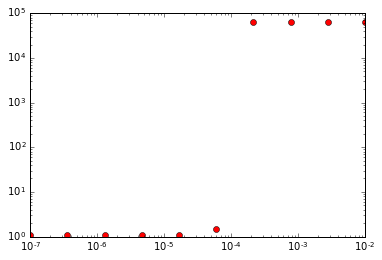

In [98]:
#Hm_2 ->  MU+ NUE  Hm_2 ->  MU+ NUM    Hm_2 ->  MU+ NUT

y = []

num=pd.Series(np.zeros(df.shape[0]))
den=pd.Series(np.zeros(df.shape[0]))
if 'Hm_2 ->  MU+ NUT' in df:
    num = num+df['Hm_2 ->  MU+ NUT']    
if 'Hm_2 ->  MU+ NUM' in df:
    num=num+df['Hm_2 ->  MU+ NUM']
if 'Hm_2 ->  MU+ NUE' in df:
    num=num+df['Hm_2 ->  MU+ NUE']
    
if 'Hm_2 ->  TAUden.shape[0]:+ NUT' in df:
    den = den+df['Hm_2 ->  TAU+ NUT']
if 'Hm_2 ->  TAU+ NUM' in df:
    den=den+df['Hm_2 ->  TAU+ NUM']
if 'Hm_2 ->  TAU+ NUE' in df:
    den=den+df['Hm_2 ->  TAU+ NUE']
if den.unique()[0]:
    y = num/den
else:
    sys.exit('ERROR: No branchings')


plt.loglog(df.epsE33,y,'ro')

In [85]:
den=pd.Series(np.zeros(df.shape[0]))

    print 1

In [77]:
np.unique())+df['Hm_2 ->  MU+ NUT']==   df['Hm_2 ->  MU+ NUT'])

array([ True], dtype=bool)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
     ..
68    0
69    0
70    0
71    0
72    0
73    0
74    0
75    0
76    0
77    0
78    0
79    0
80    0
81    0
82    0
83    0
84    0
85    0
86    0
87    0
88    0
89    0
90    0
91    0
92    0
93    0
94    0
95    0
96    0
97    0
dtype: float64

In [ ]:
%pycat hep.py

Intro Pandas

DataFrame

In [ ]:
SS=pd.DataFrame({'A':[1,2],'B':[4,3]})
SS

Series

In [ ]:
SS.loc[1]

In [ ]:
type(SS.loc[1])

Diccionario

In [ ]:
a.Series.keys().values

[![Home](http://www.incredimail.com/images/nav%20bar/home-icon.png)](./) 
[Jupyter home](./draft.pdf)